In [27]:
import torch 
torch.manual_seed(42)

In [2]:
# need a function that gets a prediction from a model 
# and returns the prediction as a string
import torch 
import torch.nn as nn
import torch.nn.functional as F

class VGG(nn.Module):
    """
    Based on - https://github.com/kkweon/mnist-competition
    from: https://github.com/ranihorev/Kuzushiji_MNIST/blob/master/KujuMNIST.ipynb
    """
    def two_conv_pool(self, in_channels, f1, f2):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s

    def three_conv_pool(self,in_channels, f1, f2, f3):
        s = nn.Sequential(
            nn.Conv2d(in_channels, f1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f1),
            nn.ReLU(inplace=True),
            nn.Conv2d(f1, f2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f2),
            nn.ReLU(inplace=True),
            nn.Conv2d(f2, f3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(f3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        for m in s.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        return s


    def __init__(self, num_classes=62):
        super(VGG, self).__init__()
        self.l1 = self.two_conv_pool(1, 64, 64)
        self.l2 = self.two_conv_pool(64, 128, 128)
        self.l3 = self.three_conv_pool(128, 256, 256, 256)
        self.l4 = self.three_conv_pool(256, 256, 256, 256)

        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


In [20]:
import math
def predict(model, img):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0)
        output = model(img)
        pred = output.argmax(dim=1, keepdim=True)
        return str(pred.item())

def load_model():
    model = VGG()
    model.load_state_dict(torch.load('models/vgg_model_EMNIST.ckpt', map_location=torch.device('cpu')))
    return model

def number_to_letter(num):
    return chr(num + 65)

model = load_model()
img = torch.rand(1, 28, 28)
print(predict(model, img))

23


/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_50992/2215201978.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/vgg

In [23]:
import torchvision.transforms as transforms
from torchvision import datasets

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transforms.ToTensor())

# Analysis

In [78]:
import pandas as pd
import os
import numpy as np
from collections import Counter

for depth in range(1, 8):
    base_folder = f'docs/neuron_EMNIST_depth_{depth}/'
    # Get all the folders
    folders = os.listdir(base_folder)

    # Create a master DataFrame to store neuron label counts
    neuron_label_counts = []

    labels = train_dataset.targets
    labels = labels.numpy()

    for dir in folders:
        # Load CSV file
        df = pd.read_csv(os.path.join(base_folder, dir, 'indexes_and_activations.csv'))

        # Skip if there are too few rows
        if len(df) < 10:
            continue

        # Get label set for current neuron
        set_labels = labels[df['Index']]
        set_labels = [number_to_letter(x) for x in set_labels]  # Assuming `number_to_letter` is defined

        # Count occurrences of each label
        label_counts = Counter(set_labels)

        # Extract neuron identifier
        neuron_id = dir.split('_')[2]

        # Append label counts to master list
        for label, count in label_counts.items():
            neuron_label_counts.append({
                'neuron': neuron_id,
                'label': label,
                'count': count
            })

    # Convert list to DataFrame for easier analysis
    neuron_df = pd.DataFrame(neuron_label_counts)
    neuron_df.to_csv(f'neuron_label_counts_depth_{depth}.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_neuron_depth_data():
    # Initialize dictionary to store data across depths
    depth_data = {}

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            # Load data for each depth
            df = pd.read_csv(file_path)
            print(f"Data from {file_path} loaded successfully.")
            
            # Ensure the file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                print(f"Warning: {file_path} does not have the required columns.")
                continue
            
            # Store dataframe in dictionary
            depth_data[i] = df

            # Plot per-depth label counts
            plt.figure(figsize=(10, 6))
            sns.barplot(data=df, x='label', y='count', estimator=sum, ci=None, palette='viridis')
            plt.title(f"Label Activation Counts at Depth {i}")
            plt.xlabel("Label")
            plt.ylabel("Activation Count")
            plt.xticks(rotation=45)
            plt.savefig(f"label_activation_counts_depth_{i}.png")
            plt.show()

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty or does not contain valid data.")
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

    # If we have data across multiple depths, proceed with cross-depth analysis
    if depth_data:
        # Combine all data into one DataFrame for cross-depth comparison
        combined_df = pd.concat([df.assign(depth=depth) for depth, df in depth_data.items()])
        
        # Plot cross-depth comparison of label activation counts
        plt.figure(figsize=(12, 8))
        sns.lineplot(data=combined_df, x='depth', y='count', hue='label', marker='o', ci=None, palette="tab10")
        plt.title("Activation Count for Each Label Across Depths")
        plt.xlabel("Depth")
        plt.ylabel("Activation Count")
        plt.legend(title="Label")
        plt.xticks(range(1, 8))
        plt.savefig("activation_count_across_depths.png")
        plt.show()

        # Grouped bar plot across depths for each label
        plt.figure(figsize=(14, 8))
        sns.barplot(data=combined_df, x='label', y='count', hue='depth', ci=None, palette="viridis")
        plt.title("Activation Counts for Each Label Across Depths")
        plt.xlabel("Label")
        plt.ylabel("Activation Count")
        plt.legend(title="Depth")
        plt.xticks(rotation=45)
        plt.savefig("activation_counts_for_each_label_across_depths.png")
        plt.show()

# Run the analysis
analyze_neuron_depth_data()

In [90]:
# a chart of the amount of neurons that activate on each number of activations. So count of neurons that have 4 same lable, 5 same labels, etc per layer 
    # Initialize dictionary to store data across depths
depth_data = {}

# Loop through each depth
for i in range(1, 8):
    file_path = f'neuron_label_counts_depth_{i}.csv'
    
    try:
        # Load data for each depth
        df = pd.read_csv(file_path)
        print(f"Data from {file_path} loaded successfully.")
        
        # Ensure the file has the expected columns
        if not {'neuron', 'label', 'count'}.issubset(df.columns):
            print(f"Warning: {file_path} does not have the required columns.")
            continue
        
        # Store dataframe in dictionary
        depth_data[i] = df
    except pd.errors.EmptyDataError:
        print(f"Warning: {file_path} is empty or does not contain valid data.")
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")
    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")

if depth_data:
    # Combine all data into one DataFrame for cross-depth comparison
    combined_df = pd.concat([df.assign(depth=depth) for depth, df in depth_data.items()])

Data from neuron_label_counts_depth_1.csv loaded successfully.
Data from neuron_label_counts_depth_2.csv loaded successfully.
Data from neuron_label_counts_depth_3.csv loaded successfully.
Data from neuron_label_counts_depth_4.csv loaded successfully.
Data from neuron_label_counts_depth_5.csv loaded successfully.
Data from neuron_label_counts_depth_6.csv loaded successfully.


In [91]:
combined_df.head()

neuron label  count  depth
0    1245     B      1      1
1    1245     L      1      1
2    1245     J      1      1
3    1245     X      1      1
4    1245     Q      2      1

Data from neuron_label_counts_depth_1.csv loaded successfully.
Data from neuron_label_counts_depth_2.csv loaded successfully.
Data from neuron_label_counts_depth_3.csv loaded successfully.
Data from neuron_label_counts_depth_4.csv loaded successfully.
Data from neuron_label_counts_depth_5.csv loaded successfully.
Data from neuron_label_counts_depth_6.csv loaded successfully.


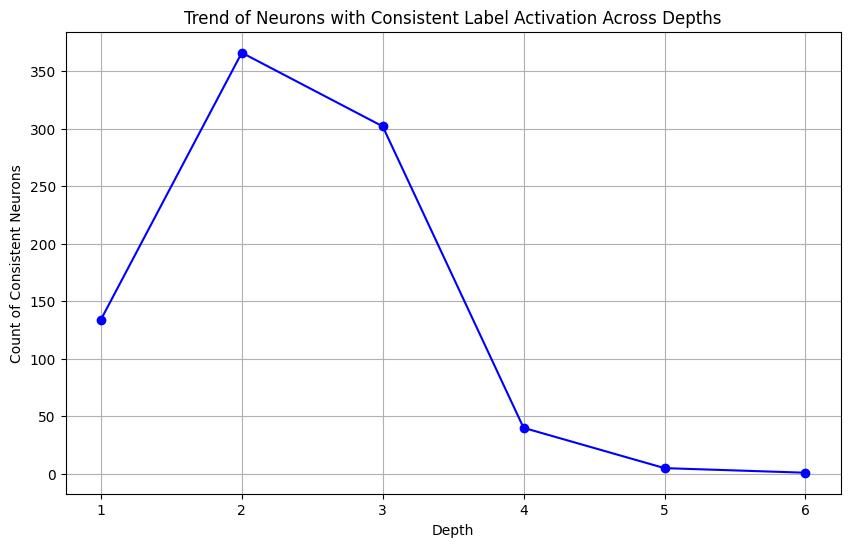

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def analyze_neuron_consistency():
    # Initialize a list to store the consistency counts for each depth
    consistency_counts = []

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            # Load data for the current depth
            df = pd.read_csv(file_path)
            print(f"Data from {file_path} loaded successfully.")
            
            # Ensure the file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                print(f"Warning: {file_path} does not have the required columns.")
                continue
            
            # Find neurons with consistent activations
            # Group by neuron, then check if all activations for a neuron are for the same label and exactly 10
            consistent_neurons = df.groupby('neuron').filter(lambda x: (x['count'].sum() == 10) and (len(x) == 7))
            
            # Count the number of consistent neurons for this depth
            consistency_counts.append({
                'depth': i,
                'consistent_neurons': consistent_neurons['neuron'].nunique()
            })

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty or does not contain valid data.")
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

    # Convert consistency counts to a DataFrame for easy plotting
    consistency_df = pd.DataFrame(consistency_counts)

    # Plot the trend of consistent neurons across depths
    plt.figure(figsize=(10, 6))
    plt.plot(consistency_df['depth'], consistency_df['consistent_neurons'], marker='o', linestyle='-', color='b')
    plt.xlabel("Depth")
    plt.ylabel("Count of Consistent Neurons")
    plt.title("Trend of Neurons with Consistent Label Activation Across Depths")
    plt.grid()
    plt.show()

# Run the analysis
analyze_neuron_consistency()


Data from neuron_label_counts_depth_1.csv loaded successfully.
Data from neuron_label_counts_depth_2.csv loaded successfully.
Data from neuron_label_counts_depth_3.csv loaded successfully.
Data from neuron_label_counts_depth_4.csv loaded successfully.
Data from neuron_label_counts_depth_5.csv loaded successfully.
Data from neuron_label_counts_depth_6.csv loaded successfully.


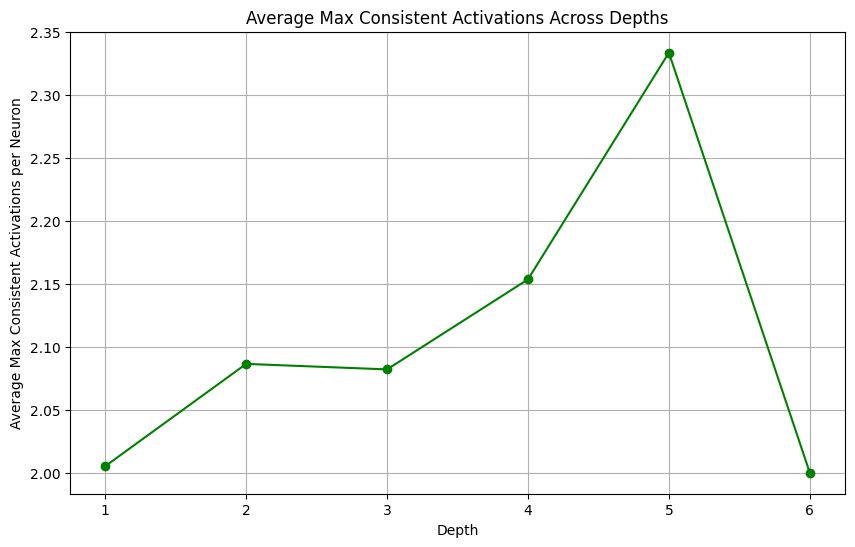

<Figure size 640x480 with 0 Axes>

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_neuron_partial_consistency():
    # Initialize a list to store average maximum activation counts for each depth
    partial_consistency_counts = []

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            # Load data for the current depth
            df = pd.read_csv(file_path)
            print(f"Data from {file_path} loaded successfully.")
            
            # Ensure the file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                print(f"Warning: {file_path} does not have the required columns.")
                continue
            
            # For each neuron, find the max count of activations for any single label
            max_label_counts = df.groupby('neuron')['count'].max()
            
            # Calculate the average maximum activation count across neurons
            avg_max_count = max_label_counts.mean()
            partial_consistency_counts.append({
                'depth': i,
                'average_max_consistent_activations': avg_max_count
            })

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty or does not contain valid data.")
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

    # Convert the results to a DataFrame for plotting
    partial_consistency_df = pd.DataFrame(partial_consistency_counts)

    # Plot the trend of average max consistent activations across depths
    plt.figure(figsize=(10, 6))
    plt.plot(partial_consistency_df['depth'], partial_consistency_df['average_max_consistent_activations'],
             marker='o', linestyle='-', color='g')
    plt.xlabel("Depth")
    plt.ylabel("Average Max Consistent Activations per Neuron")
    plt.title("Average Max Consistent Activations Across Depths")
    plt.grid()
    plt.show()
    plt.savefig('plots/average_max_consistent_activations_EMNIST.png')

# Run the analysis
analyze_neuron_partial_consistency()


Data from neuron_label_counts_depth_1.csv loaded successfully.
Data from neuron_label_counts_depth_2.csv loaded successfully.
Data from neuron_label_counts_depth_3.csv loaded successfully.
Data from neuron_label_counts_depth_4.csv loaded successfully.
Data from neuron_label_counts_depth_5.csv loaded successfully.
Data from neuron_label_counts_depth_6.csv loaded successfully.


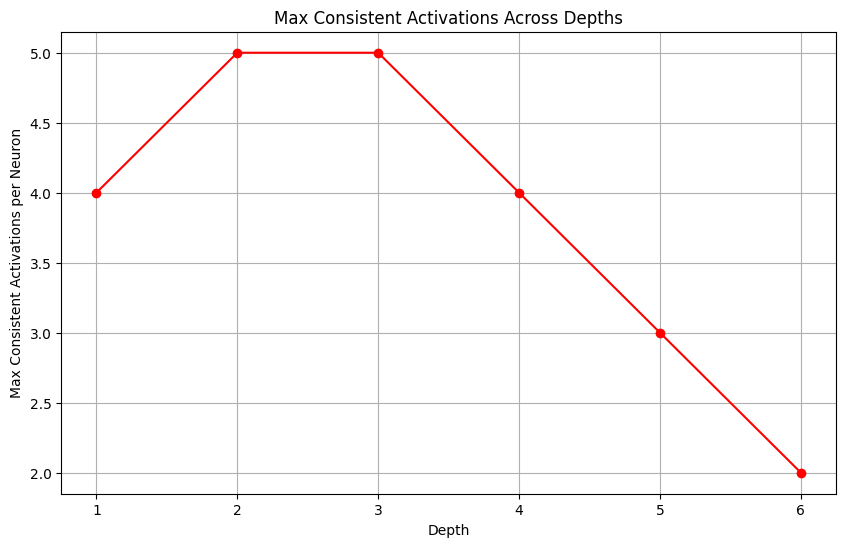

<Figure size 640x480 with 0 Axes>

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_neuron_max_consistency():
    # Initialize a list to store max consistency counts for each depth
    max_consistency_counts = []

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            # Load data for the current depth
            df = pd.read_csv(file_path)
            print(f"Data from {file_path} loaded successfully.")
            
            # Ensure the file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                print(f"Warning: {file_path} does not have the required columns.")
                continue
            
            # For each neuron, find the max count of activations for any single label
            max_label_counts = df.groupby('neuron')['count'].max()
            
            # Find the maximum of these max counts for this depth
            max_consistent_activation = max_label_counts.max()
            max_consistency_counts.append({
                'depth': i,
                'max_consistent_activations': max_consistent_activation
            })

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty or does not contain valid data.")
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

    # Convert the results to a DataFrame for plotting
    max_consistency_df = pd.DataFrame(max_consistency_counts)

    # Plot the trend of max consistent activations across depths
    plt.figure(figsize=(10, 6))
    plt.plot(max_consistency_df['depth'], max_consistency_df['max_consistent_activations'],
             marker='o', linestyle='-', color='r')
    plt.xlabel("Depth")
    plt.ylabel("Max Consistent Activations per Neuron")
    plt.title("Max Consistent Activations Across Depths")
    plt.grid()
    plt.show()
    plt.savefig('plots/max_consistent_activations_EMNIST.png')

# Run the analysis
analyze_neuron_max_consistency()


Data from neuron_label_counts_depth_1.csv loaded successfully.
Data from neuron_label_counts_depth_2.csv loaded successfully.
Data from neuron_label_counts_depth_3.csv loaded successfully.
Data from neuron_label_counts_depth_4.csv loaded successfully.
Data from neuron_label_counts_depth_5.csv loaded successfully.
Data from neuron_label_counts_depth_6.csv loaded successfully.


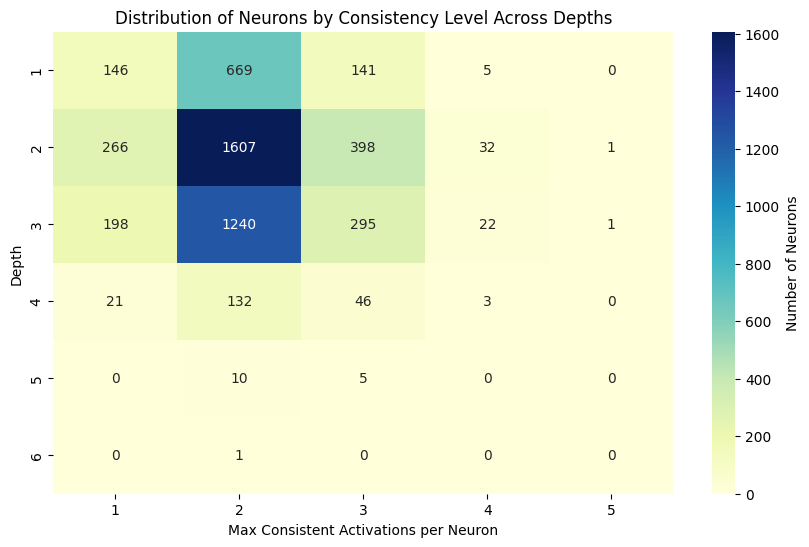

<Figure size 640x480 with 0 Axes>

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_neuron_consistency_distribution():
    # Initialize a DataFrame to store consistency counts for each depth and activation level
    consistency_data = []

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            # Load data for the current depth
            df = pd.read_csv(file_path)
            print(f"Data from {file_path} loaded successfully.")
            
            # Ensure the file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                print(f"Warning: {file_path} does not have the required columns.")
                continue
            
            # For each neuron, find the max count of activations for any single label
            max_label_counts = df.groupby('neuron')['count'].max()
            
            # Count occurrences of each consistency level (1, 2, ..., 10) for this depth
            consistency_counts = max_label_counts.value_counts().sort_index()
            
            # Add data to the consistency_data list
            for count, num_neurons in consistency_counts.items():
                consistency_data.append({
                    'depth': i,
                    'consistent_activation_count': count,
                    'num_neurons': num_neurons
                })

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty or does not contain valid data.")
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

    # Convert the data into a DataFrame suitable for a heatmap
    consistency_df = pd.DataFrame(consistency_data)
    
    # Pivot the data for heatmap plotting (depths as rows, counts as columns)
    heatmap_data = consistency_df.pivot(index="depth", columns="consistent_activation_count", values="num_neurons").fillna(0)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Number of Neurons'})
    plt.xlabel("Max Consistent Activations per Neuron")
    plt.ylabel("Depth")
    plt.title("Distribution of Neurons by Consistency Level Across Depths")
    plt.show()
    plt.savefig('plots/consistency_distribution_EMNIST.png')

# Run the analysis
analyze_neuron_consistency_distribution()


Data from neuron_label_counts_depth_1.csv loaded successfully.
Data from neuron_label_counts_depth_2.csv loaded successfully.
Data from neuron_label_counts_depth_3.csv loaded successfully.
Data from neuron_label_counts_depth_4.csv loaded successfully.
Data from neuron_label_counts_depth_5.csv loaded successfully.
Data from neuron_label_counts_depth_6.csv loaded successfully.


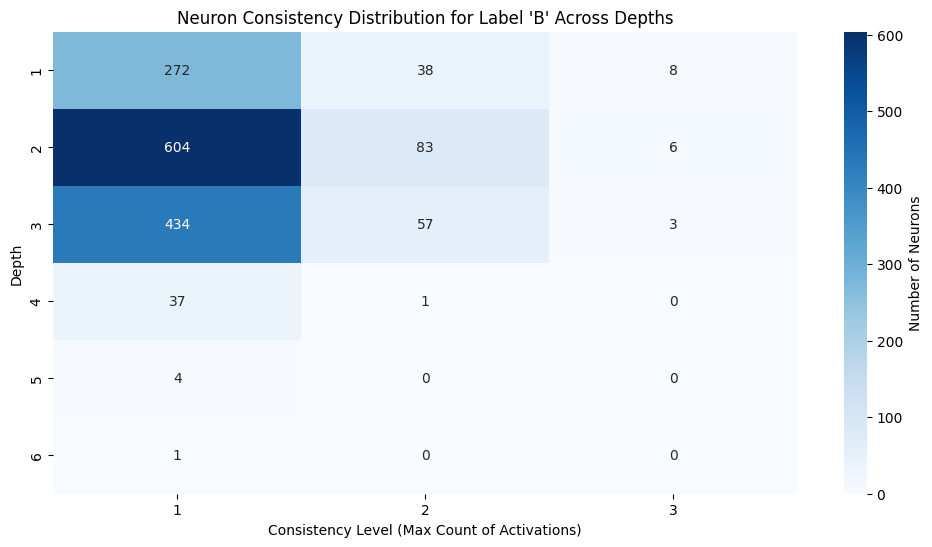

<Figure size 640x480 with 0 Axes>

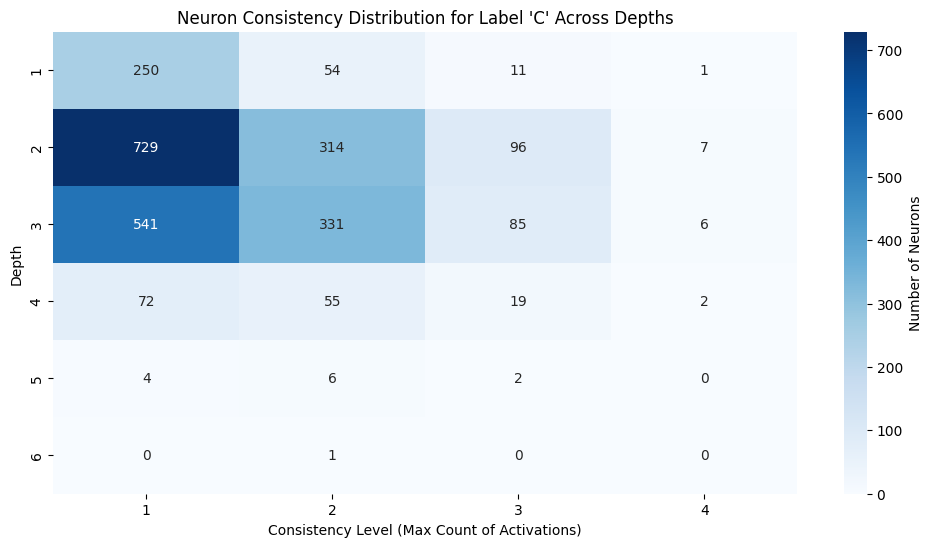

<Figure size 640x480 with 0 Axes>

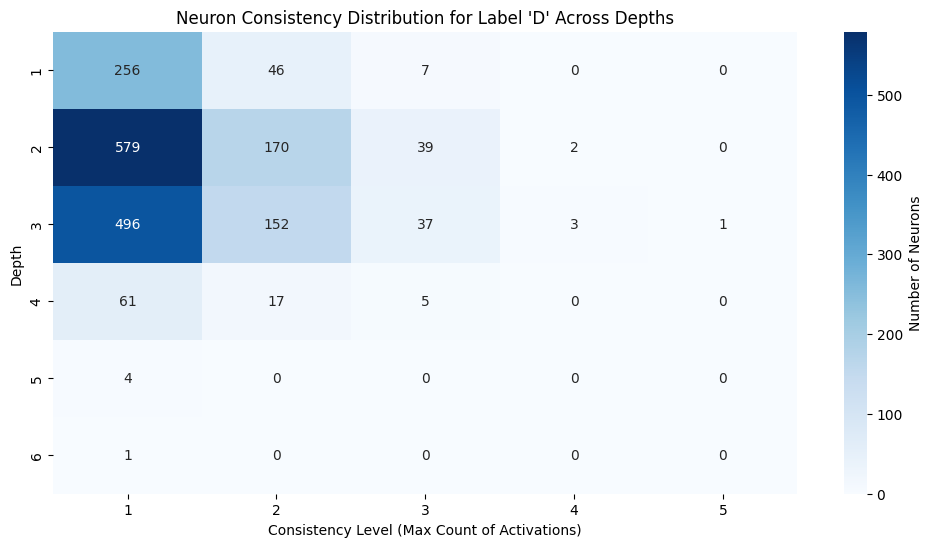

<Figure size 640x480 with 0 Axes>

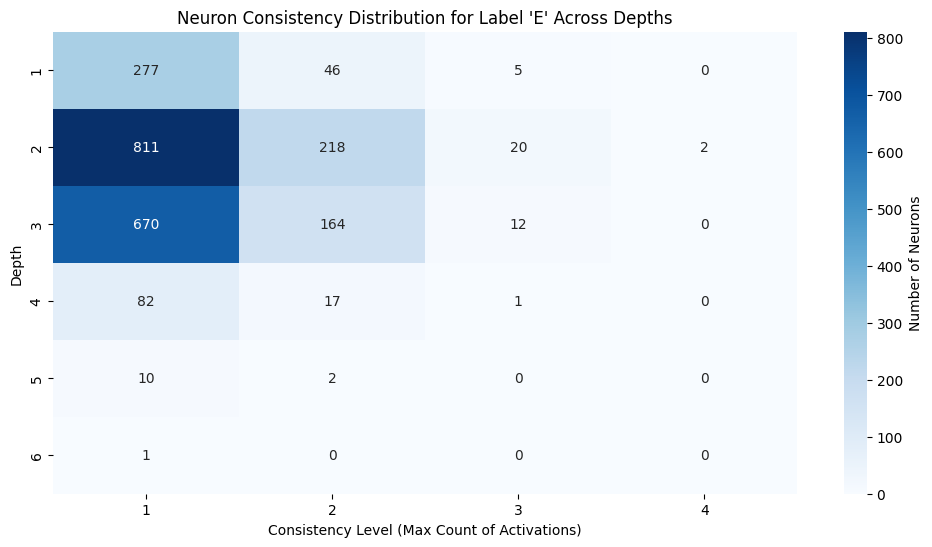

<Figure size 640x480 with 0 Axes>

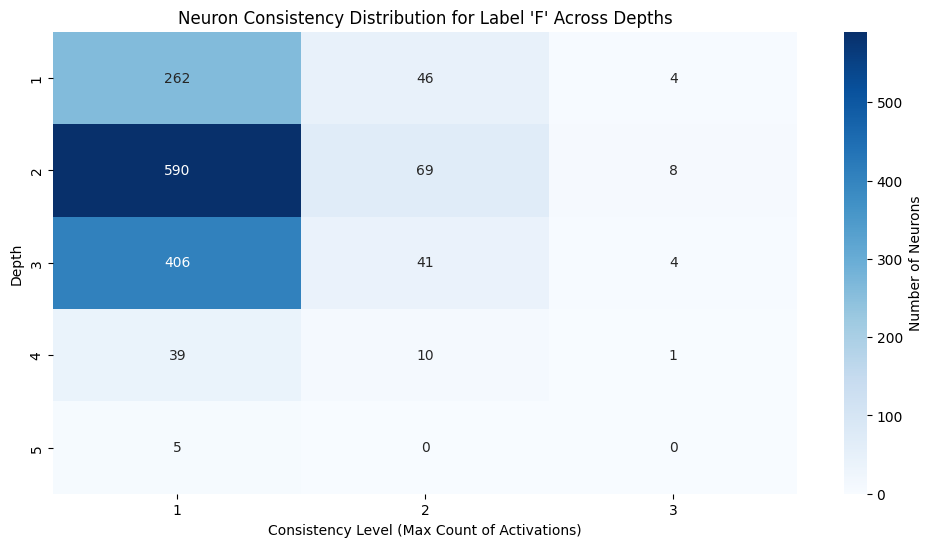

<Figure size 640x480 with 0 Axes>

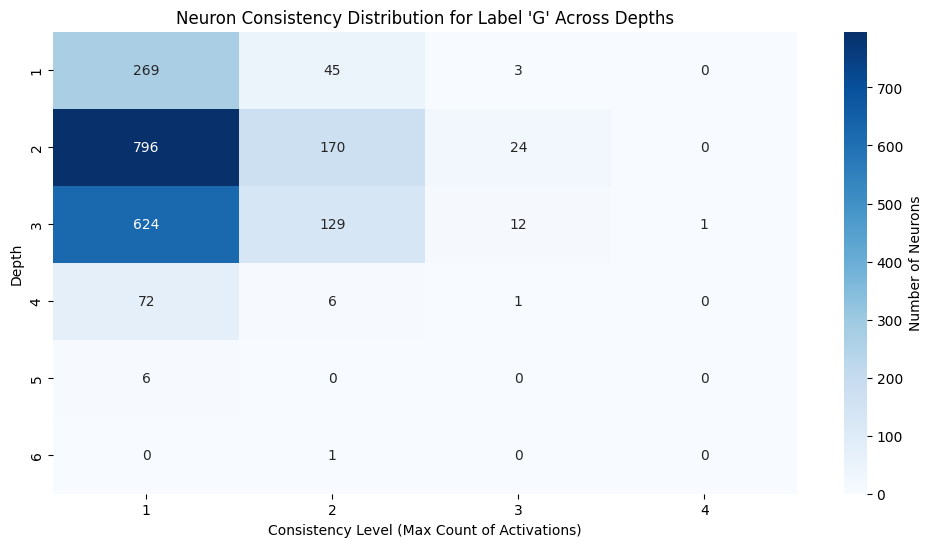

<Figure size 640x480 with 0 Axes>

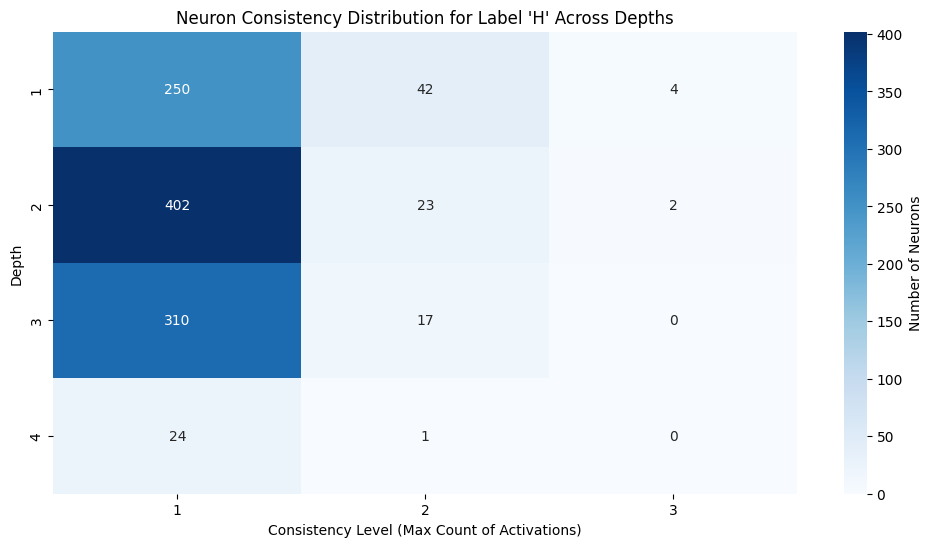

<Figure size 640x480 with 0 Axes>

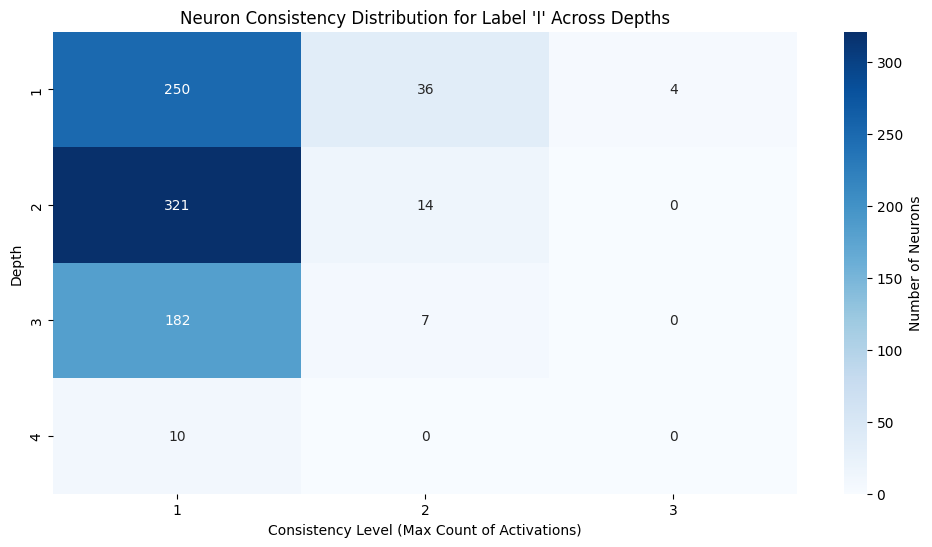

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

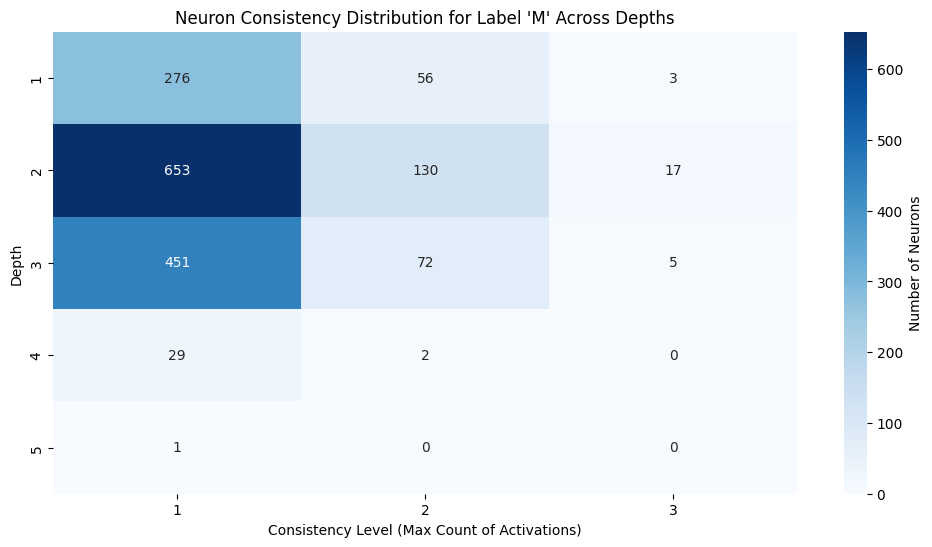

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

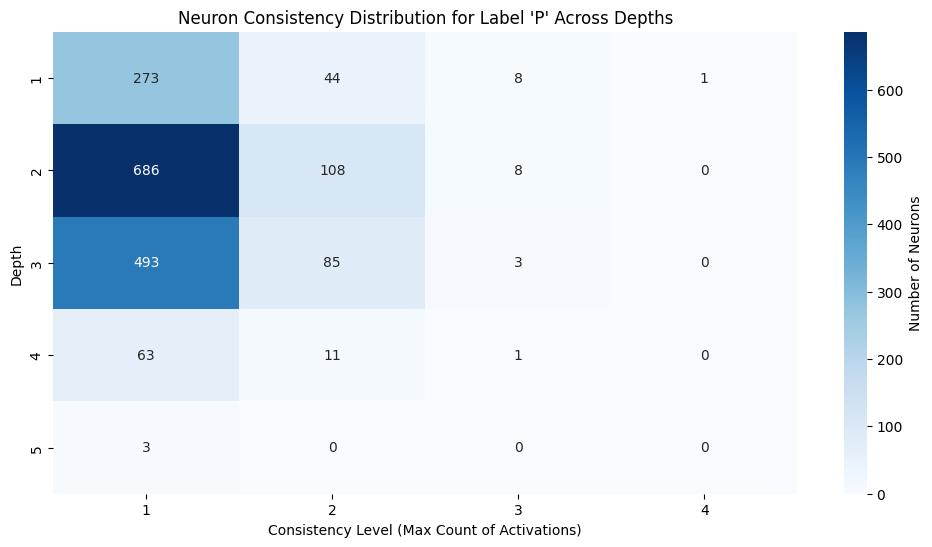

<Figure size 640x480 with 0 Axes>

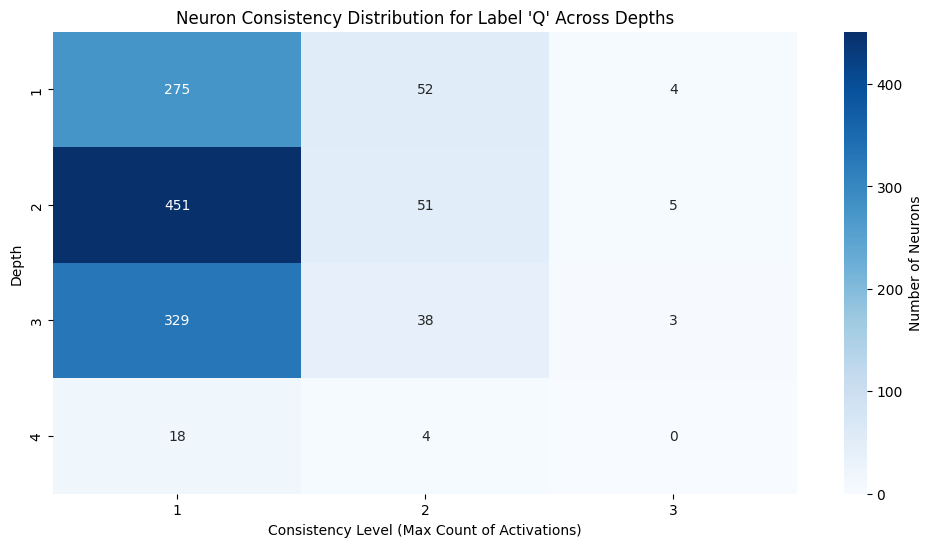

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

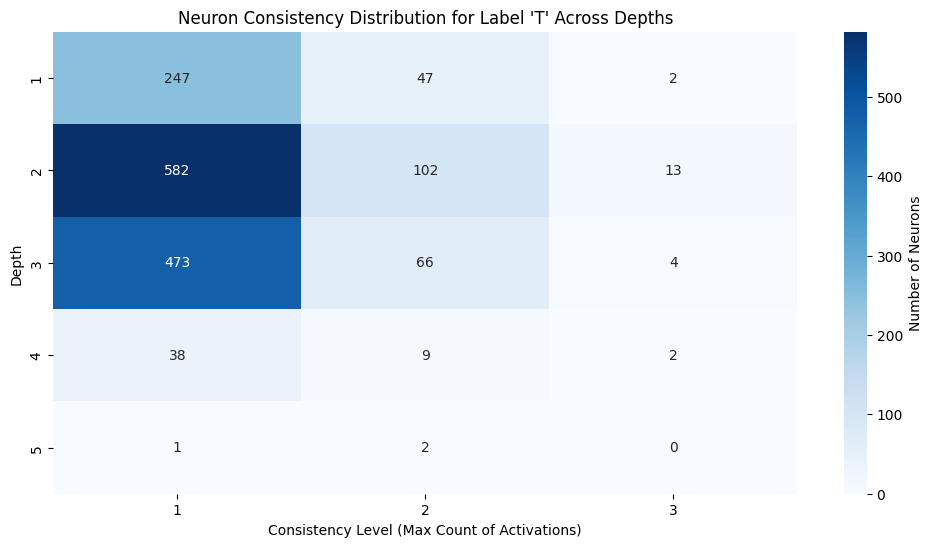

<Figure size 640x480 with 0 Axes>

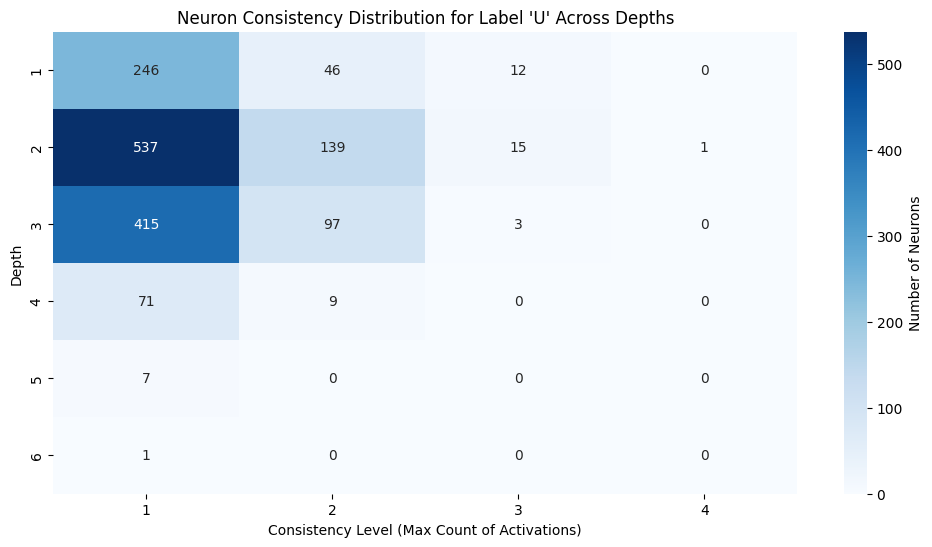

<Figure size 640x480 with 0 Axes>

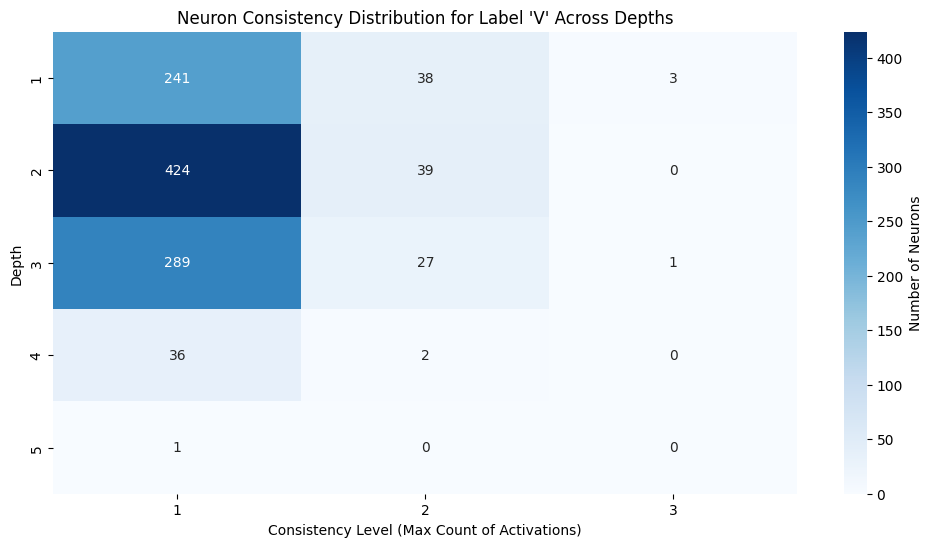

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

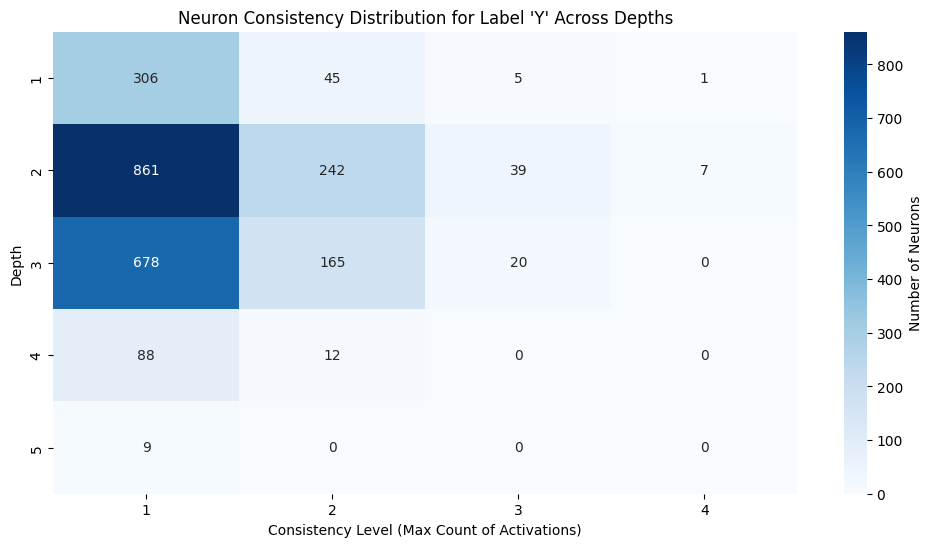

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_label_consistency_distribution():
    # Initialize a list to store consistency data for each label at each depth
    consistency_data = []

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            # Load data for the current depth
            df = pd.read_csv(file_path)
            print(f"Data from {file_path} loaded successfully.")
            
            # Ensure the file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                print(f"Warning: {file_path} does not have the required columns.")
                continue
            
            # For each neuron, find the max count of activations for any single label
            max_label_counts = df.groupby(['neuron', 'label'])['count'].max().reset_index()
            
            # For each label, count how many neurons have each consistency level
            consistency_counts = max_label_counts.groupby(['label', 'count']).size().reset_index(name='num_neurons')
            consistency_counts['depth'] = i
            
            # Append data to consistency_data list
            consistency_data.extend(consistency_counts.to_dict(orient='records'))

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty or does not contain valid data.")
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

    # Convert the collected data to a DataFrame
    consistency_df = pd.DataFrame(consistency_data)

    # Pivot the data to prepare it for heatmap plotting (depths as rows, consistency levels as columns)
    for label in consistency_df['label'].unique():
        label_df = consistency_df[consistency_df['label'] == label].pivot(index="depth", columns="count", values="num_neurons").fillna(0)

        # Plot the heatmap for the current label
        plt.figure(figsize=(12, 6))
        sns.heatmap(label_df, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Number of Neurons'})
        plt.xlabel("Consistency Level (Max Count of Activations)")
        plt.ylabel("Depth")
        plt.title(f"Neuron Consistency Distribution for Label '{label}' Across Depths")
        plt.show()
        plt.savefig(f'plots/label_consistency_distribution_EMNIST_{label}.png')

# Run the analysis
analyze_label_consistency_distribution()

Data from neuron_label_counts_depth_1.csv loaded successfully.
Data from neuron_label_counts_depth_2.csv loaded successfully.
Data from neuron_label_counts_depth_3.csv loaded successfully.
Data from neuron_label_counts_depth_4.csv loaded successfully.
Data from neuron_label_counts_depth_5.csv loaded successfully.
Data from neuron_label_counts_depth_6.csv loaded successfully.


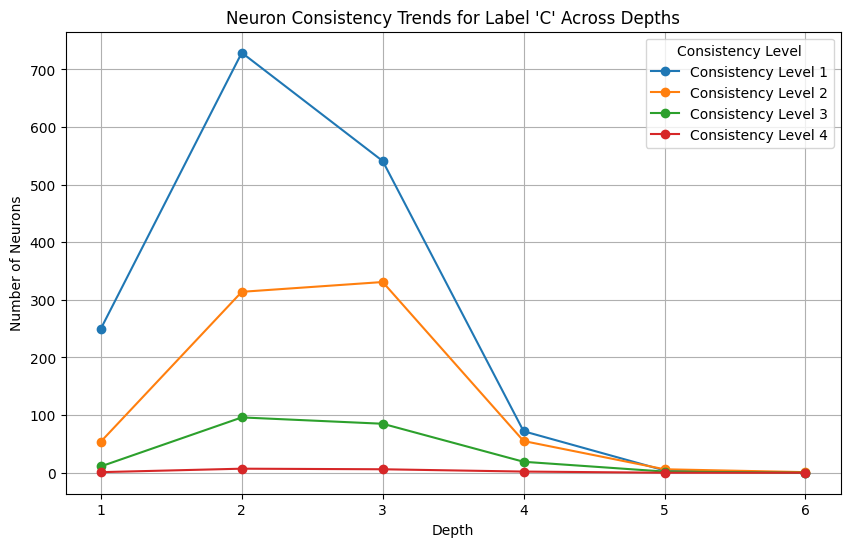

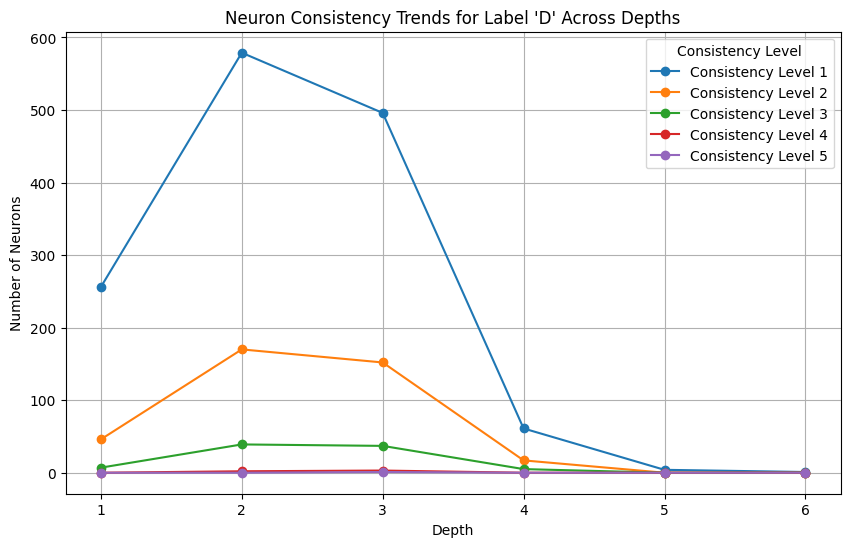

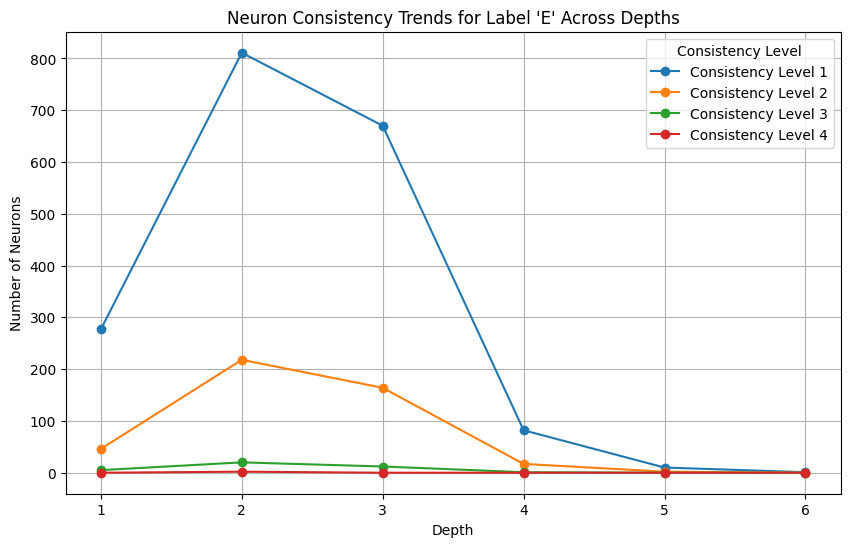

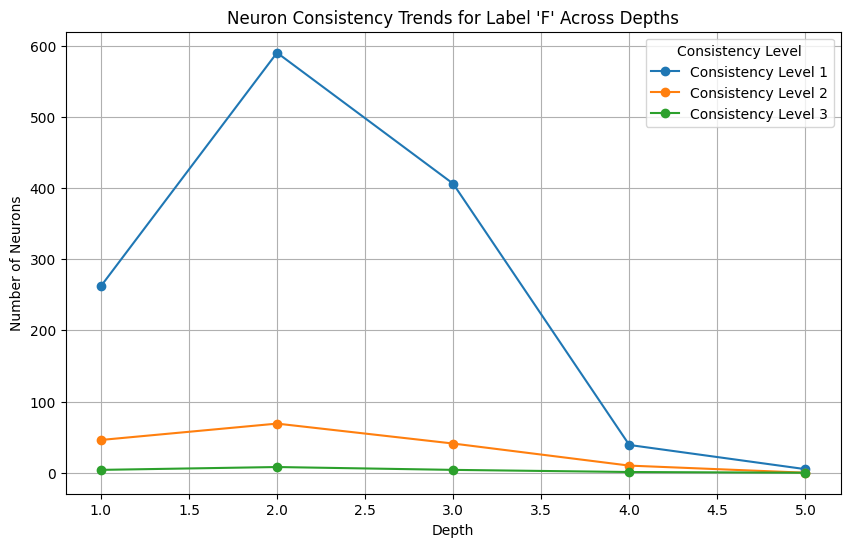

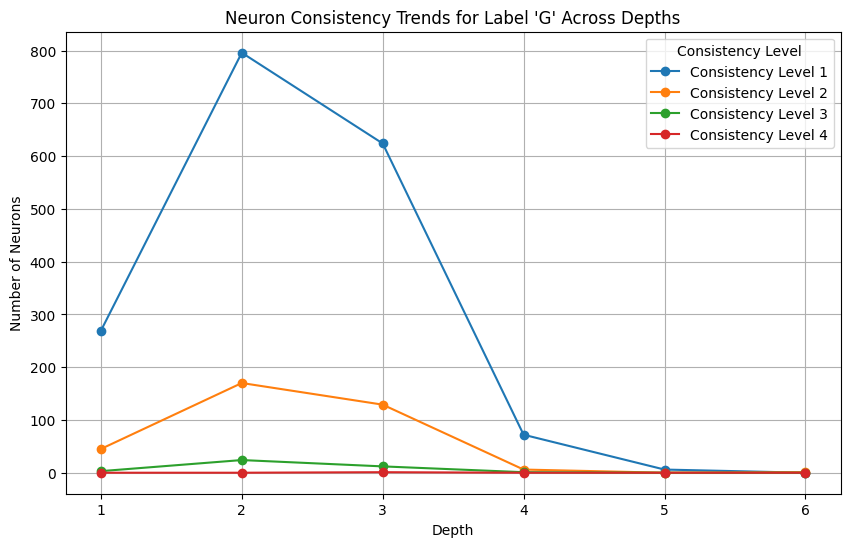

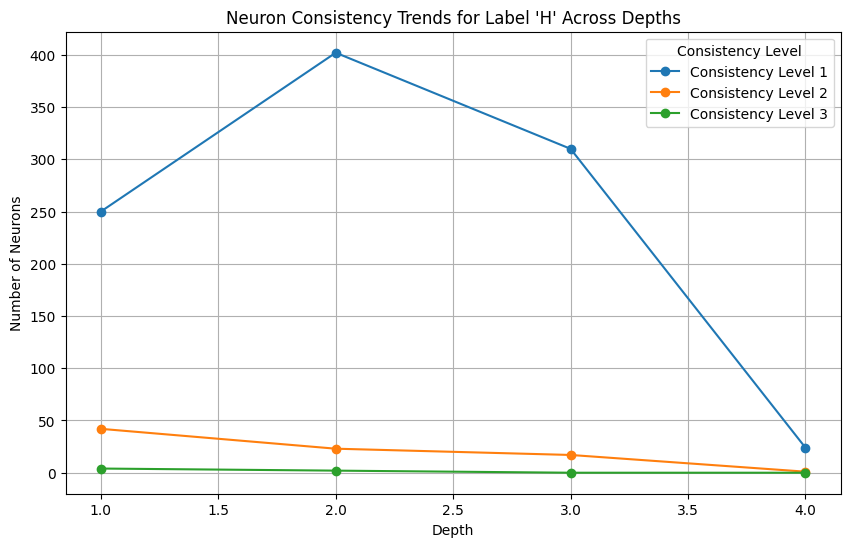

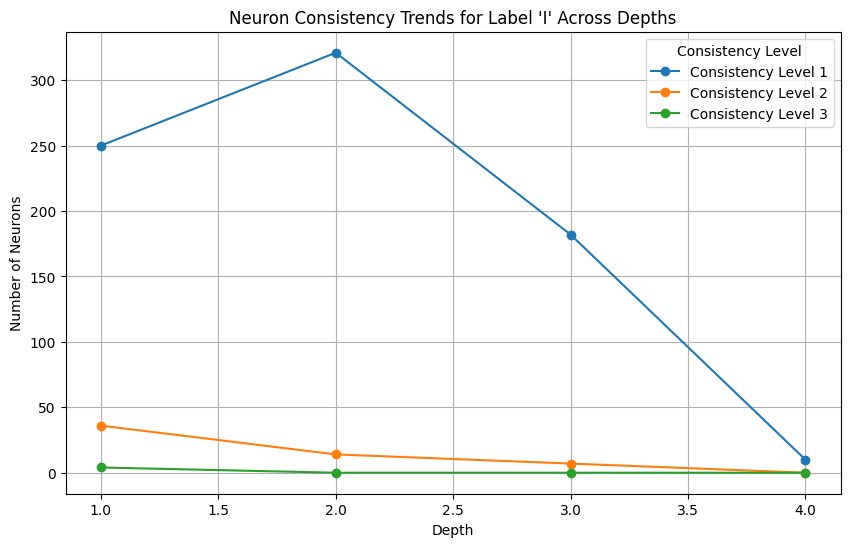

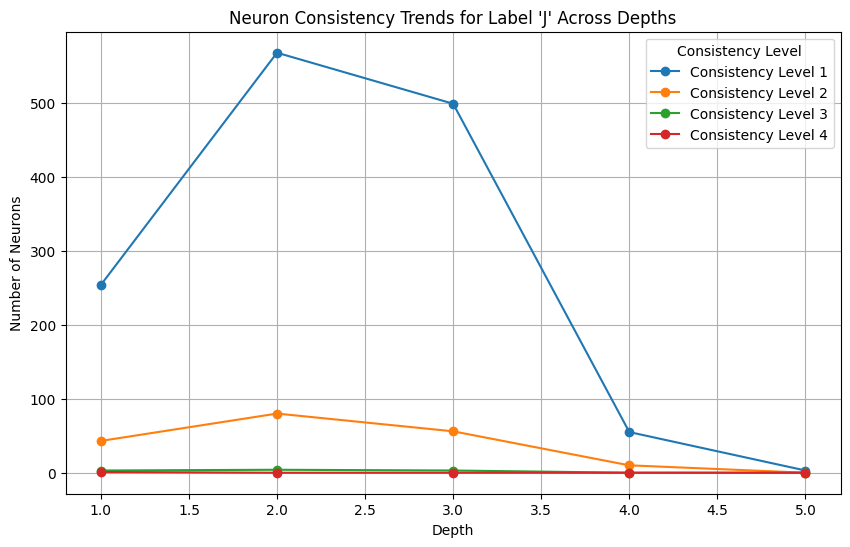

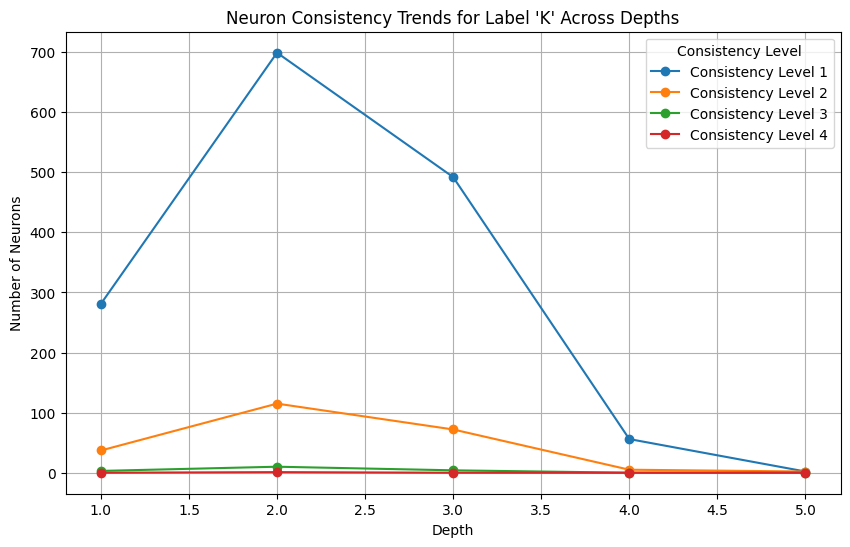

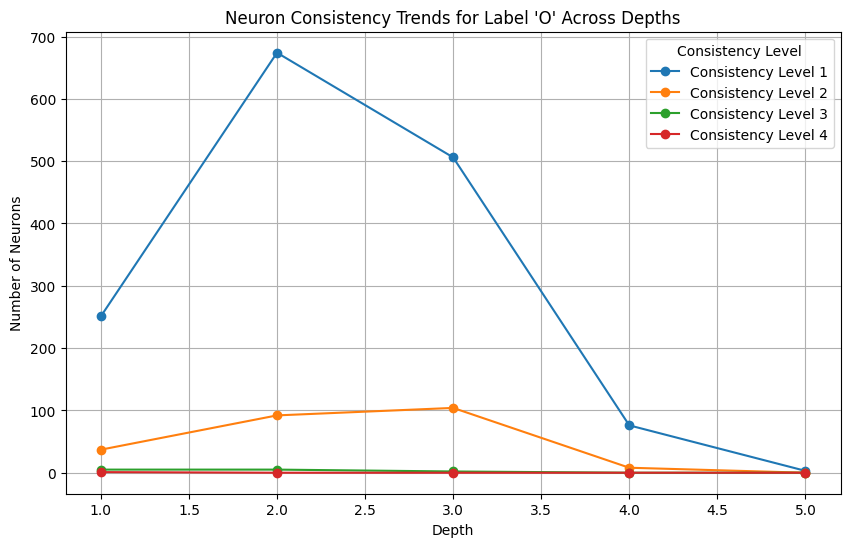

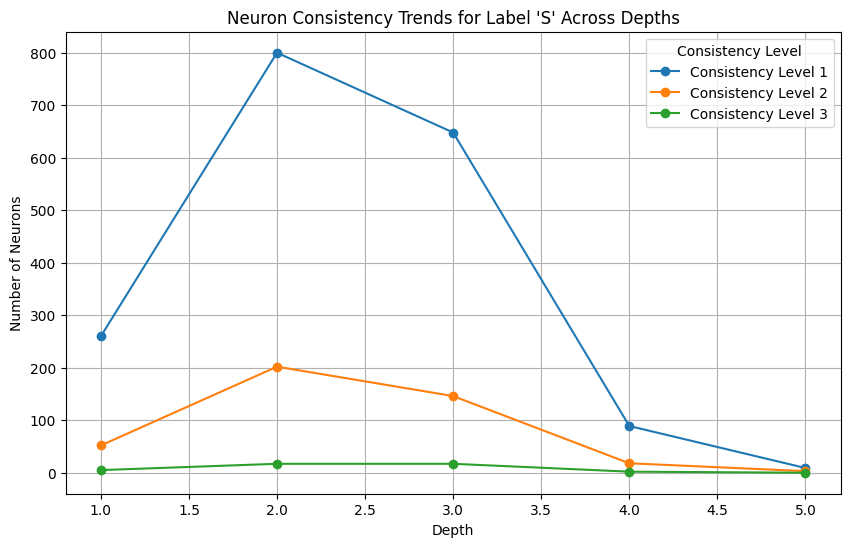

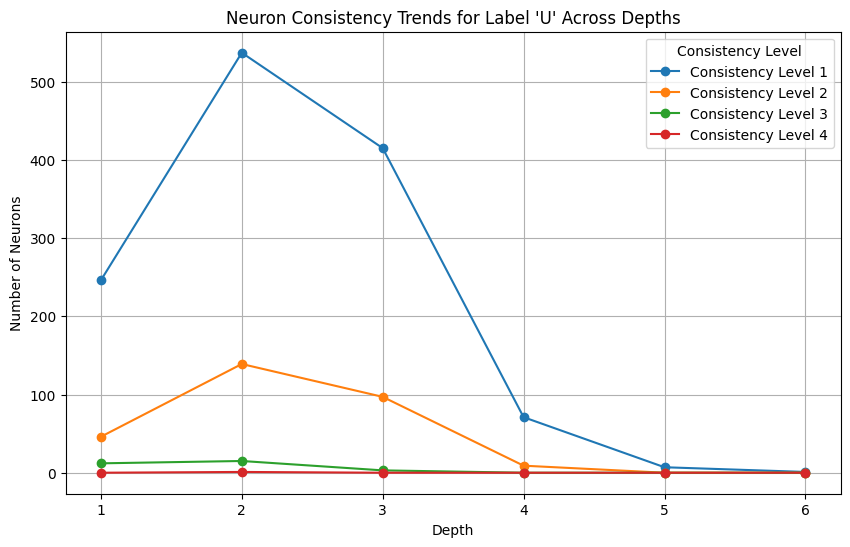

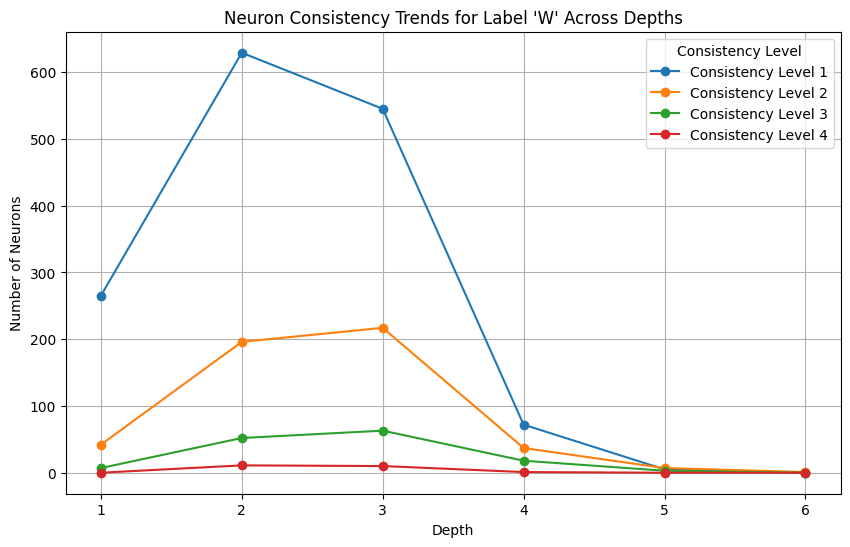

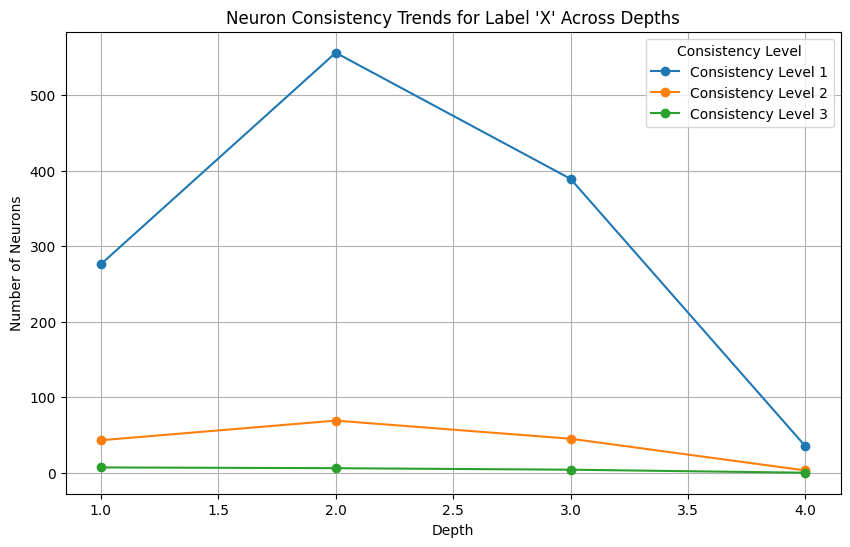

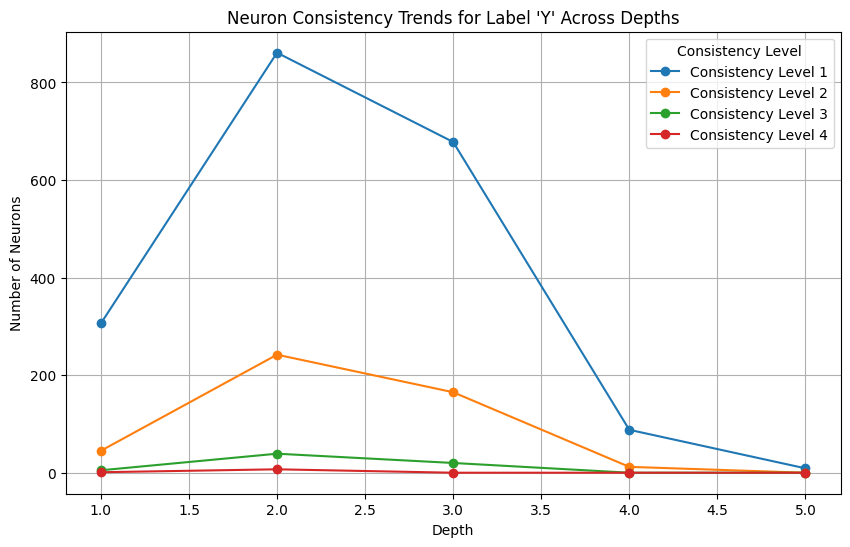

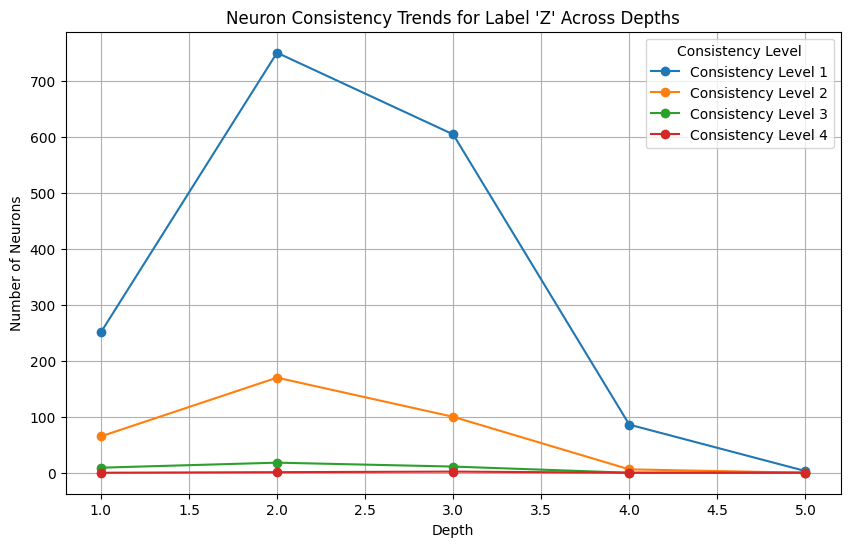

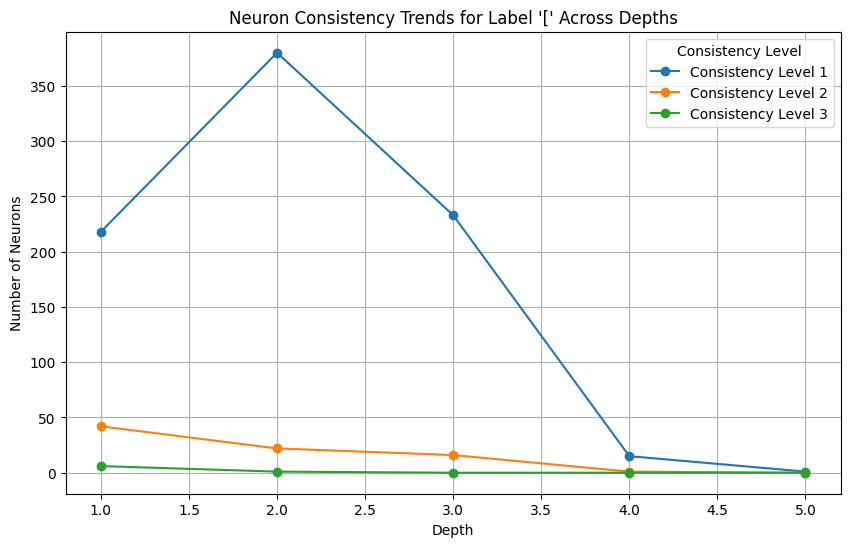

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_label_consistency_trends():
    # Initialize a list to store consistency data for each label at each depth
    consistency_data = []

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            # Load data for the current depth
            df = pd.read_csv(file_path)
            print(f"Data from {file_path} loaded successfully.")
            
            # Ensure the file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                print(f"Warning: {file_path} does not have the required columns.")
                continue
            
            # For each neuron, find the max count of activations for any single label
            max_label_counts = df.groupby(['neuron', 'label'])['count'].max().reset_index()
            
            # For each label, count how many neurons have each consistency level
            consistency_counts = max_label_counts.groupby(['label', 'count']).size().reset_index(name='num_neurons')
            consistency_counts['depth'] = i
            
            # Append data to consistency_data list
            consistency_data.extend(consistency_counts.to_dict(orient='records'))

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty or does not contain valid data.")
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

    # Convert the collected data to a DataFrame
    consistency_df = pd.DataFrame(consistency_data)

    # Plot trends for each label
    for label in consistency_df['label'].unique():
        label_df = consistency_df[consistency_df['label'] == label].pivot(index="depth", columns="count", values="num_neurons").fillna(0)

        # Plot the line chart for consistency trends across depths
        plt.figure(figsize=(10, 6))
        for consistency_level in label_df.columns:
            plt.plot(label_df.index, label_df[consistency_level], marker='o', label=f'Consistency Level {consistency_level}')
        
        plt.xlabel("Depth")
        plt.ylabel("Number of Neurons")
        plt.title(f"Neuron Consistency Trends for Label '{label}' Across Depths")
        plt.legend(title="Consistency Level")
        plt.grid()
        plt.show()

# Run the analysis
analyze_label_consistency_trends()

Data from neuron_label_counts_depth_1.csv loaded successfully.
Data from neuron_label_counts_depth_2.csv loaded successfully.
Data from neuron_label_counts_depth_3.csv loaded successfully.
Data from neuron_label_counts_depth_4.csv loaded successfully.
Data from neuron_label_counts_depth_5.csv loaded successfully.
Data from neuron_label_counts_depth_6.csv loaded successfully.


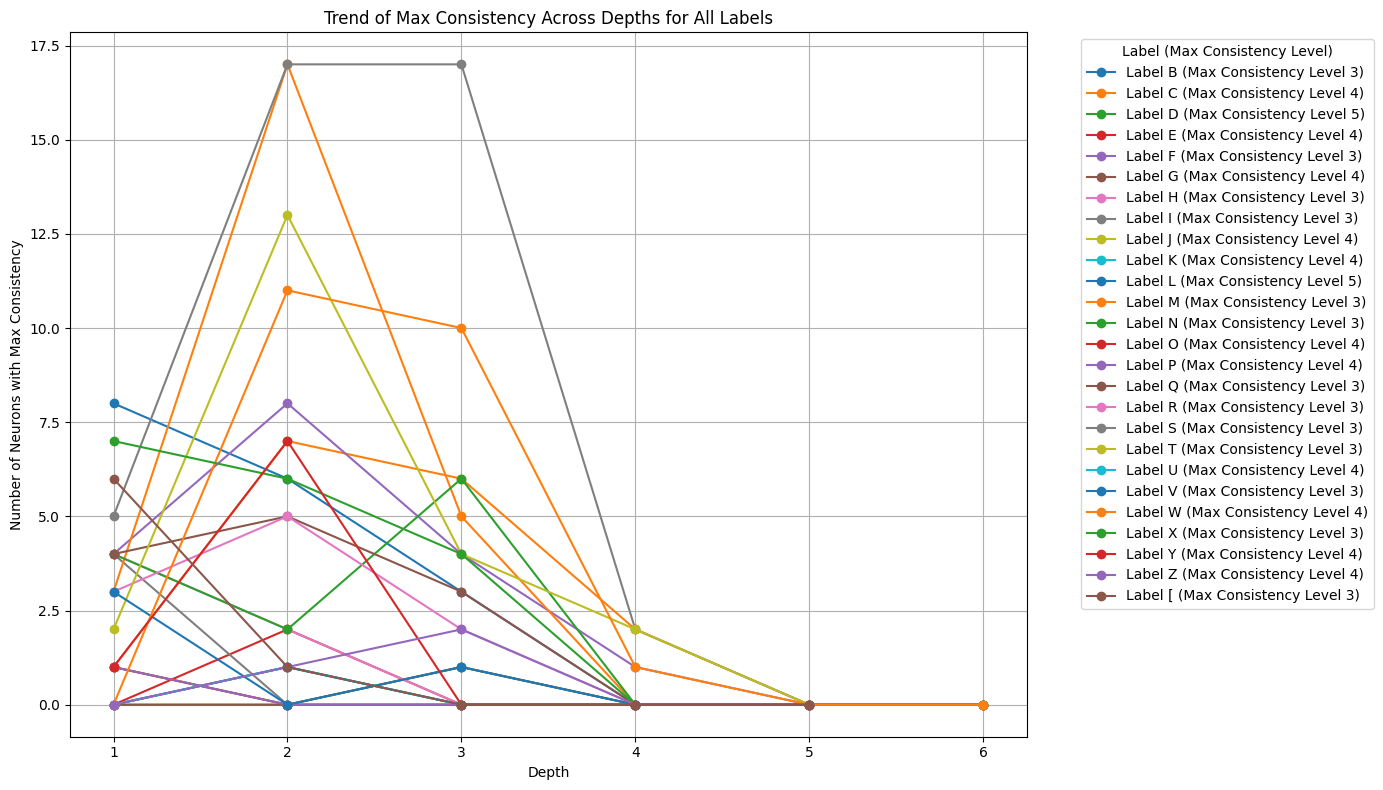

<Figure size 640x480 with 0 Axes>

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_all_labels_consistency_trends():
    # Initialize a list to store consistency data for each label at each depth
    consistency_data = []

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            # Load data for the current depth
            df = pd.read_csv(file_path)
            print(f"Data from {file_path} loaded successfully.")
            
            # Ensure the file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                print(f"Warning: {file_path} does not have the required columns.")
                continue
            
            # For each neuron, find the max count of activations for any single label
            max_label_counts = df.groupby(['neuron', 'label'])['count'].max().reset_index()
            
            # For each label, count how many neurons have each consistency level
            consistency_counts = max_label_counts.groupby(['label', 'count']).size().reset_index(name='num_neurons')
            consistency_counts['depth'] = i
            
            # Append data to consistency_data list
            consistency_data.extend(consistency_counts.to_dict(orient='records'))

        except pd.errors.EmptyDataError:
            print(f"Warning: {file_path} is empty or does not contain valid data.")
        except FileNotFoundError:
            print(f"Error: {file_path} not found.")
        except Exception as e:
            print(f"An error occurred while reading {file_path}: {e}")

    # Convert the collected data to a DataFrame
    consistency_df = pd.DataFrame(consistency_data)

    # Prepare to plot all labels on one chart
    plt.figure(figsize=(14, 8))
    
    # Loop through each unique label and plot consistency trends
    for label in consistency_df['label'].unique():
        label_df = consistency_df[consistency_df['label'] == label].pivot(index="depth", columns="count", values="num_neurons").fillna(0)
        
        # For each label, plot the trend of neurons with the highest consistency level across depths
        # Here, we assume "highest consistency level" means the max count column in label_df
        max_consistency_level = label_df.columns.max()
        plt.plot(label_df.index, label_df[max_consistency_level], marker='o', label=f'Label {label} (Max Consistency Level {max_consistency_level})')
    
    # Customize the plot
    plt.xlabel("Depth")
    plt.ylabel("Number of Neurons with Max Consistency")
    plt.title("Trend of Max Consistency Across Depths for All Labels")
    plt.legend(title="Label (Max Consistency Level)", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.savefig('plots/all_labels_consistency_trends_EMNIST.png')

# Run the analysis
analyze_all_labels_consistency_trends()

<Figure size 1400x800 with 0 Axes>

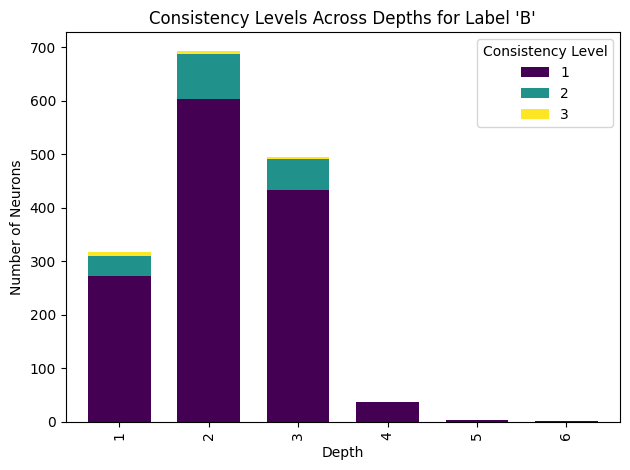

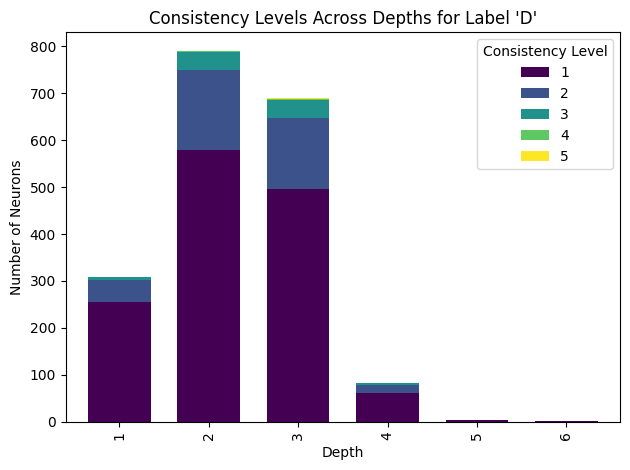

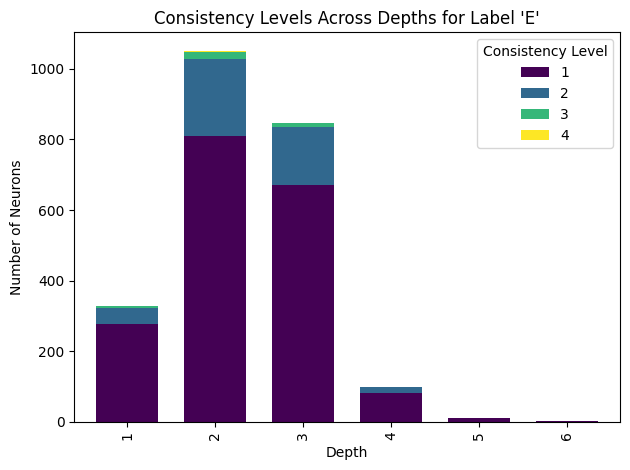

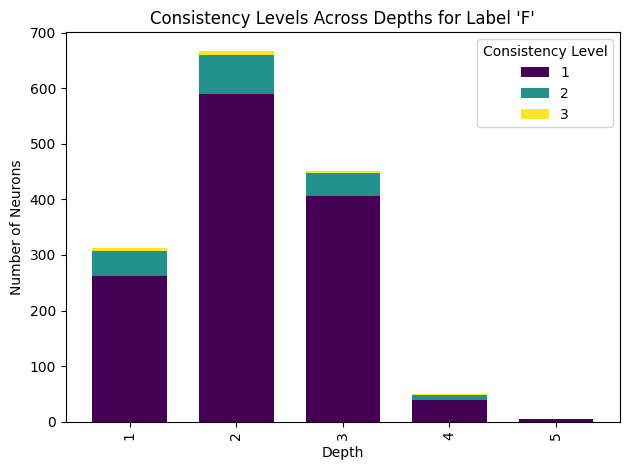

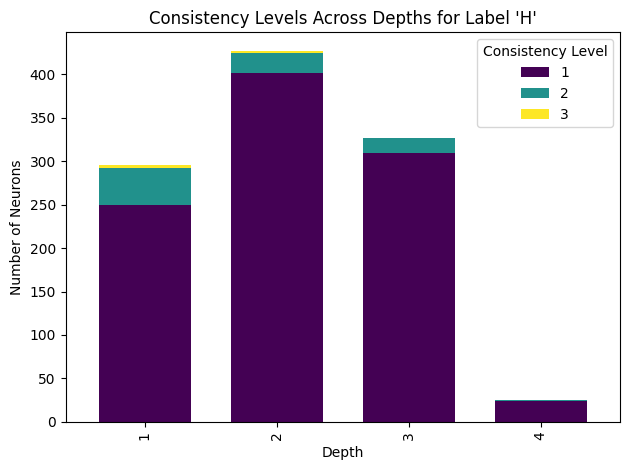

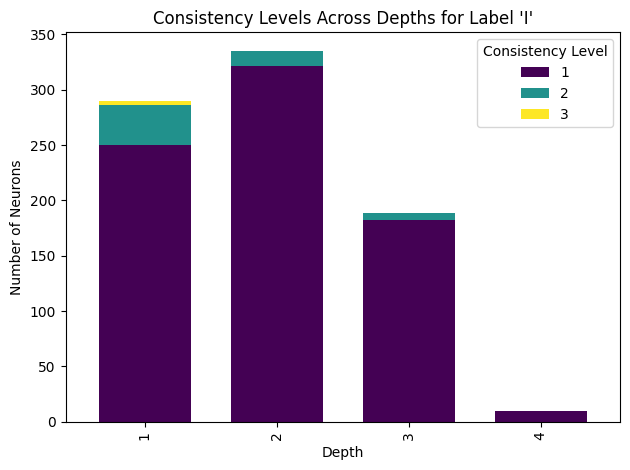

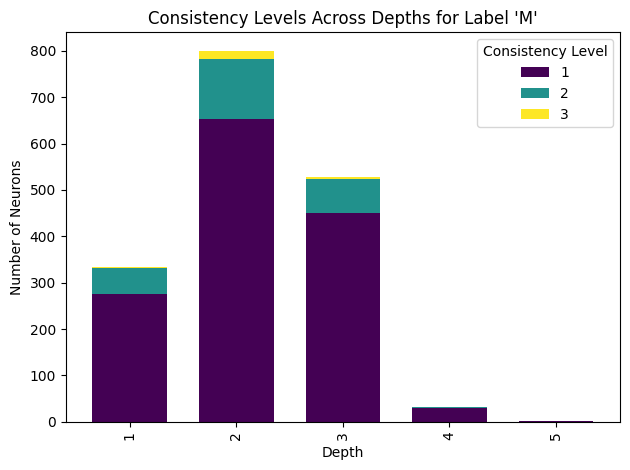

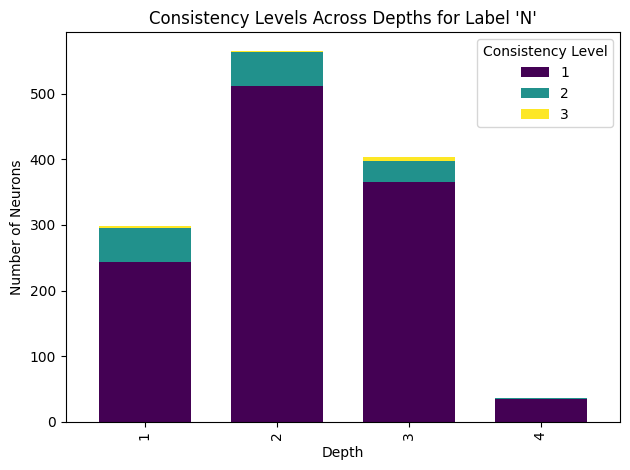

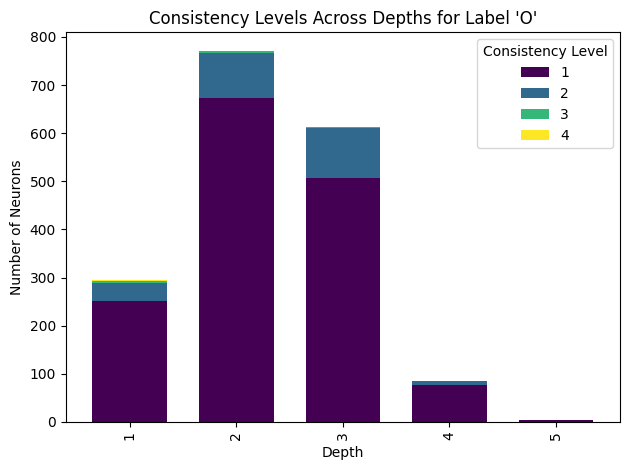

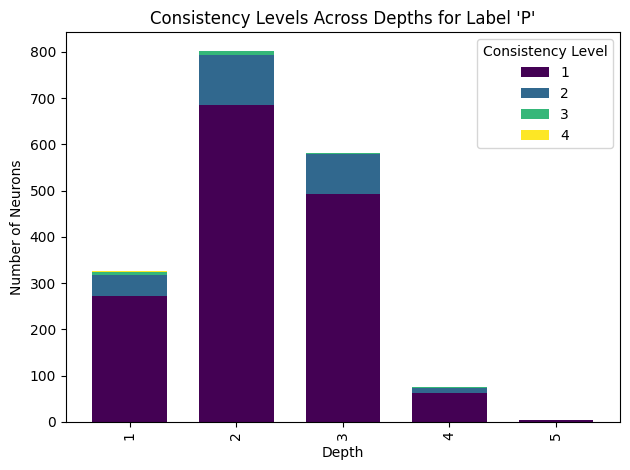

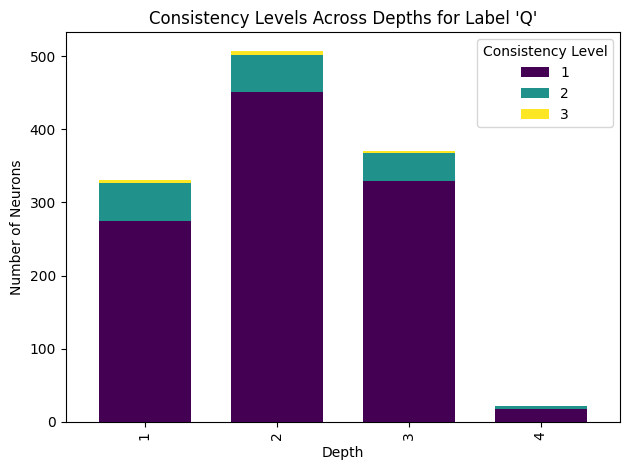

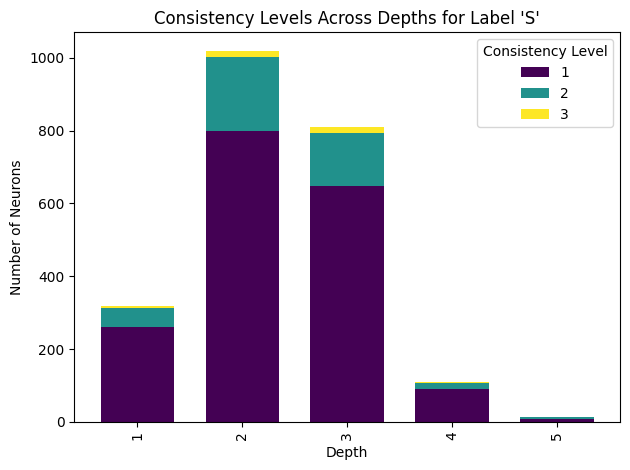

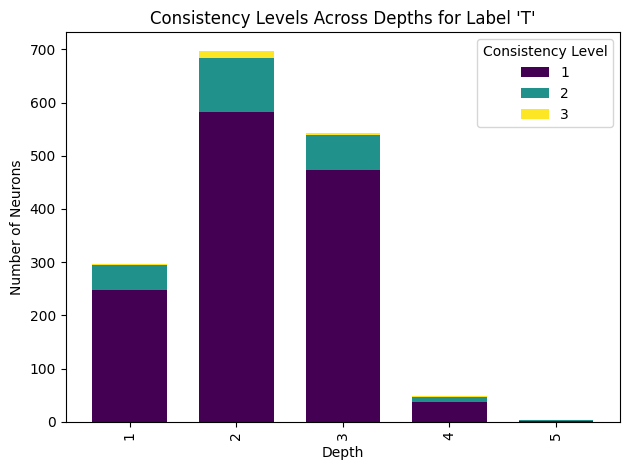

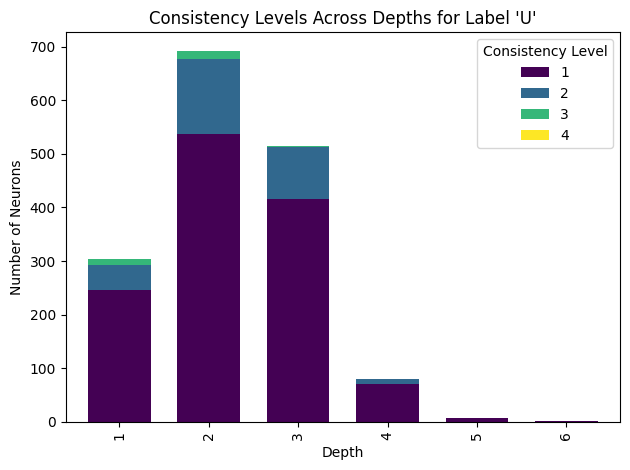

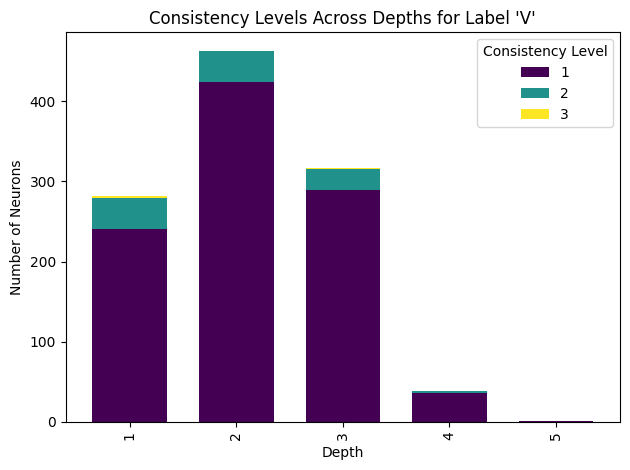

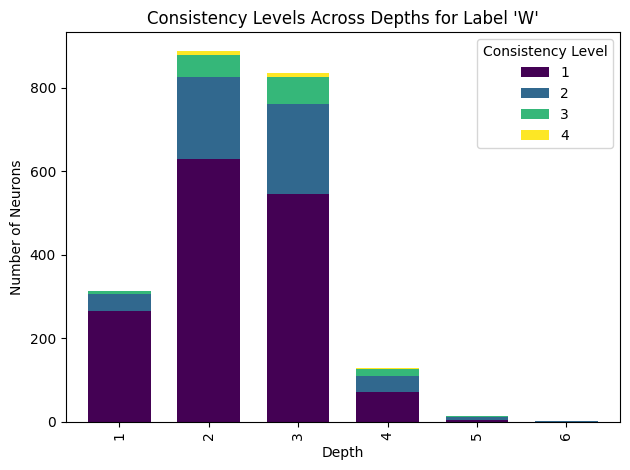

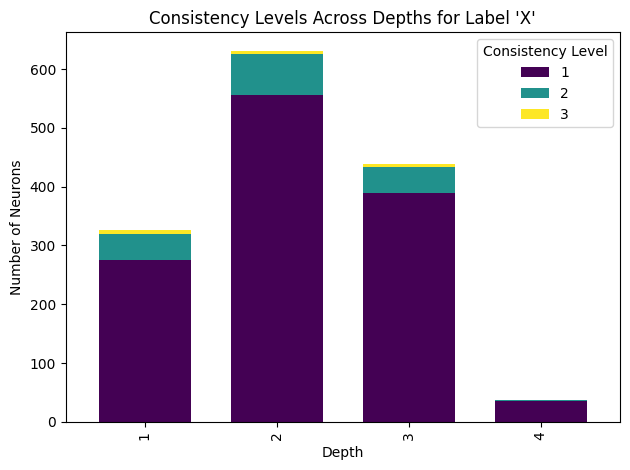

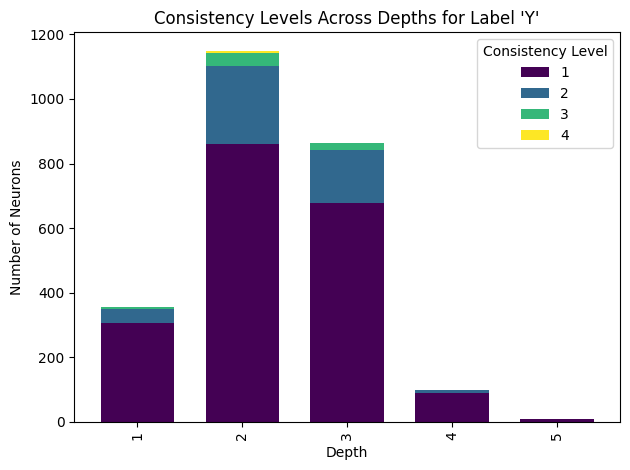

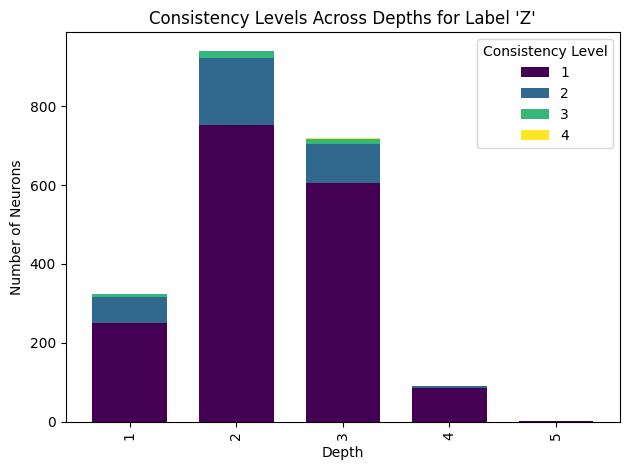

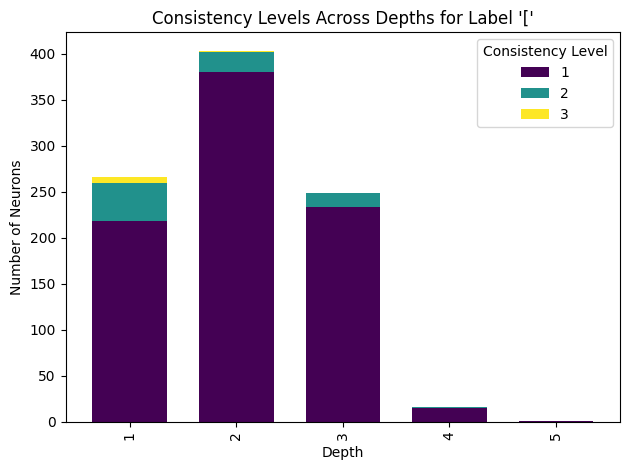

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_label_consistency_stacked_bars():
    consistency_data = []

    # Loop through each depth
    for i in range(1, 8):
        file_path = f'neuron_label_counts_depth_{i}.csv'
        
        try:
            df = pd.read_csv(file_path)
            
            # Ensure file has the expected columns
            if not {'neuron', 'label', 'count'}.issubset(df.columns):
                continue
            
            max_label_counts = df.groupby(['neuron', 'label'])['count'].max().reset_index()
            consistency_counts = max_label_counts.groupby(['label', 'count']).size().reset_index(name='num_neurons')
            consistency_counts['depth'] = i
            consistency_data.extend(consistency_counts.to_dict(orient='records'))

        except (pd.errors.EmptyDataError, FileNotFoundError):
            continue

    consistency_df = pd.DataFrame(consistency_data)

    # Plot stacked bar charts for each label
    plt.figure(figsize=(14, 8))
    
    for label in consistency_df['label'].unique():
        label_df = consistency_df[consistency_df['label'] == label].pivot(index="depth", columns="count", values="num_neurons").fillna(0)
        label_df.plot(kind='bar', stacked=True, colormap='viridis', width=0.7)
        
        plt.title(f"Consistency Levels Across Depths for Label '{label}'")
        plt.xlabel("Depth")
        plt.ylabel("Number of Neurons")
        plt.legend(title="Consistency Level")
        plt.tight_layout()
        plt.show()

# Run the analysis with stacked bar charts
visualize_label_consistency_stacked_bars()

#### Old Code 

```python
base_folder = 'docs/neuron_EMNIST_depth_7/'
# Get all the folders
folders = os.listdir(base_folder)

# Create a master DataFrame to store neuron label counts
neuron_label_counts = []

labels = train_dataset.targets
labels = labels.numpy()

for dir in folders:
    # Load CSV file
    df = pd.read_csv(os.path.join(base_folder, dir, 'indexes_and_activations.csv'))
    
    # Skip if there are too few rows
    if len(df) < 10:
        continue
    
    # Get label set for current neuron
    set_labels = labels[df['Index']]
    set_labels = [number_to_letter(x) for x in set_labels]  # Assuming `number_to_letter` is defined

    # Count occurrences of each label
    label_counts = Counter(set_labels)
    
    # Extract neuron identifier
    neuron_id = dir.split('_')[2]

    # Append label counts to master list
    for label, count in label_counts.items():
        neuron_label_counts.append({
            'neuron': neuron_id,
            'label': label,
            'count': count
        })

# Convert list to DataFrame for easier analysis
neuron_df = pd.DataFrame(neuron_label_counts)
neuron_df.to_csv('neuron_label_counts.csv', index=False)